## Forcasting in Engineering und Management

### Forecasting S&P 500 Index — A Time Series Modeling Approach

This notebook presents a comprehensive time series forecasting analysis of the S&P 500 Index, focusing on building and comparing various predictive models to estimate short-term price movements.


This notebook presents a comprehensive time series forecasting analysis of the S&P 500 Index, focusing on building and comparing various predictive models to estimate short-term price movements.

Project Goals:
Apply statistical and deep learning models to forecast S&P 500 prices.

Evaluate models using standard error metrics (MAE, RMSE, MAPE) along with advanced metrics (sMAPE, MASE).

Perform exploratory data analysis (EDA) to understand price behavior, distribution, and seasonality.

Develop a modular and reproducible workflow with configurable forecast horizons and rolling evaluation.

Models Compared:
Baseline models: Naive, Drift, Mean, Seasonal Naive

Statistical models: Simple Exponential Smoothing (SES), Holt Linear, Holt-Winters (Additive/Multiplicative), ARIMA

Advanced models: Prophet, LSTM, RNN

In [29]:
# ----------------------------------------
# Forecasting in Engineering & Management
# Main Notebook: FoEM_Projekt.ipynb
# Cleaned for S&P 500 only with TRAIN/TEST support
# ----------------------------------------

# Core packages
import pandas as pd
import numpy as np
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Statistical tools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import BDay
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.plot import plot_plotly
from statsforecast.models import Theta
from statsforecast import StatsForecast
import scipy.stats as stats
from statsmodels.tsa.stattools import acf, pacf

# ML/DL Tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Utilities
import os
import warnings
warnings.filterwarnings("ignore")
import logging
from datetime import timedelta

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [30]:
# ----------------------------------------
# GLOBAL CONFIGURATION
# ----------------------------------------

# Forecasting Settings
HISTORY_YEARS = 5               # How many years of historical data to use
FORECAST_DAYS = 261              # Flexible forecast horizon (used in models only)
TRAIN_TEST_SPLIT = 0.8          # Keep test set stable (20% of historical data)

# Ticker & Environment
TICKER = "^GSPC"                # S&P 500 Index
SEED = 42                       # For reproducibility

In [31]:
# ----------------------------------------
# LOAD & CLEAN TIME SERIES DATA
# ----------------------------------------

# Define date range
end_date = dt.datetime.today()
start_date = end_date - timedelta(days=HISTORY_YEARS * 365)

# Fetch S&P 500 data
logging.info(f"Downloading S&P 500 data from {start_date.date()} to {end_date.date()}...")
sp500 = yf.download(TICKER, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Check if MultiIndex is present (older yfinance versions)
print("\n Raw Columns from yfinance:", sp500.columns.tolist())
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = [col[0] for col in sp500.columns]

# Select relevant columns
expected_cols = ['Close', 'Open', 'High', 'Low', 'Volume']
sp500 = sp500[[col for col in expected_cols if col in sp500.columns]].copy()

# Clean index and fill missing values
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.asfreq('B')
sp500 = sp500.ffill()

# Data summary
print(f"\n Dataset Shape: {sp500.shape}")
print(f"  Time Range : {sp500.index.min().date()} → {sp500.index.max().date()}")
print(" Columns     :", ', '.join(map(str, sp500.columns)))
print("\n Missing Values:")
print(sp500.isna().sum())
print("\n Use HISTORY_YEARS in config to adjust data range.")

2025-06-19 19:57:35,306 - INFO - Downloading S&P 500 data from 2020-06-20 to 2025-06-19...



 Raw Columns from yfinance: [('Adj Close', '^GSPC'), ('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]

 Dataset Shape: (1303, 5)
  Time Range : 2020-06-22 → 2025-06-18
 Columns     : Close, Open, High, Low, Volume

 Missing Values:
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64

 Use HISTORY_YEARS in config to adjust data range.


### EDA

In [32]:
sp500.head()

,Close,Open,High,Low,Volume
Date,,,,,
2020-06-22,3117.860107,3094.419922,3120.919922,3079.389893,4.686690e+09
2020-06-23,3131.290039,3138.699951,3154.899902,3127.120117,4.711850e+09
2020-06-24,3050.330078,3114.399902,3115.010010,3032.129883,5.597680e+09
2020-06-25,3083.760010,3046.600098,3086.250000,3024.010010,4.847690e+09
2020-06-26,3009.050049,3073.199951,3073.729980,3004.629883,8.107850e+09


In [33]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2020-06-22 to 2025-06-18
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1303 non-null   float64
 1   Open    1303 non-null   float64
 2   High    1303 non-null   float64
 3   Low     1303 non-null   float64
 4   Volume  1303 non-null   float64
dtypes: float64(5)
memory usage: 61.1 KB


In [34]:
sp500.describe()

,Close,Open,High,Low,Volume
count,1303.000000,1303.000000,1303.000000,1303.000000,1.303000e+03
mean,4522.521222,4521.238153,4547.404853,4493.843044,4.313800e+09
std,766.106310,766.117319,767.070174,764.589519,9.554836e+08
min,3009.050049,3018.590088,3053.889893,2999.739990,0.000000e+00
25%,3966.845093,3963.809937,3992.625000,3935.785034,3.759055e+09
50%,4374.299805,4374.939941,4394.870117,4349.310059,4.143800e+09
75%,5082.839844,5099.714844,5119.055176,5060.120117,4.685835e+09
max,6144.149902,6134.500000,6147.430176,6111.149902,9.976520e+09


 Descriptive Statistics:
Mean     : 4522.52
Median   : 4374.30
Std Dev  : 766.11
Skewness : 0.49
Kurtosis : -0.67
Min      : 3009.05
Max      : 6144.15


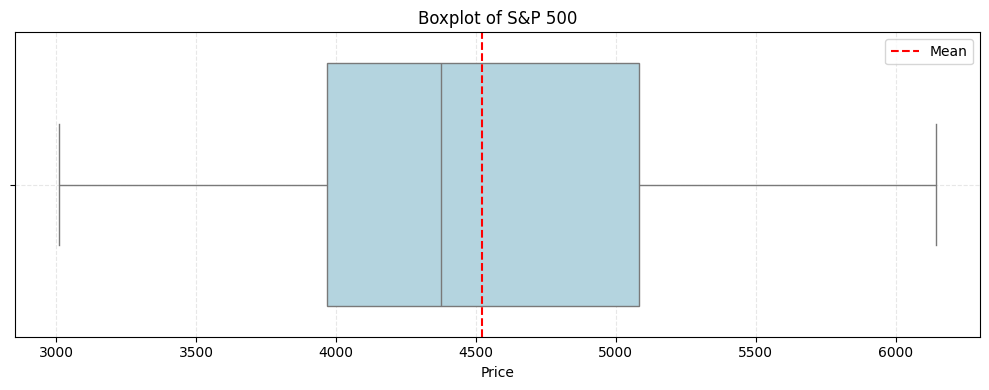

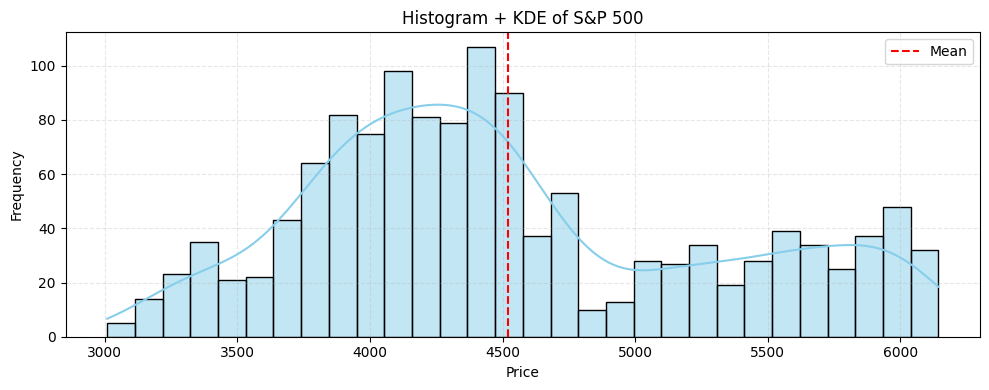

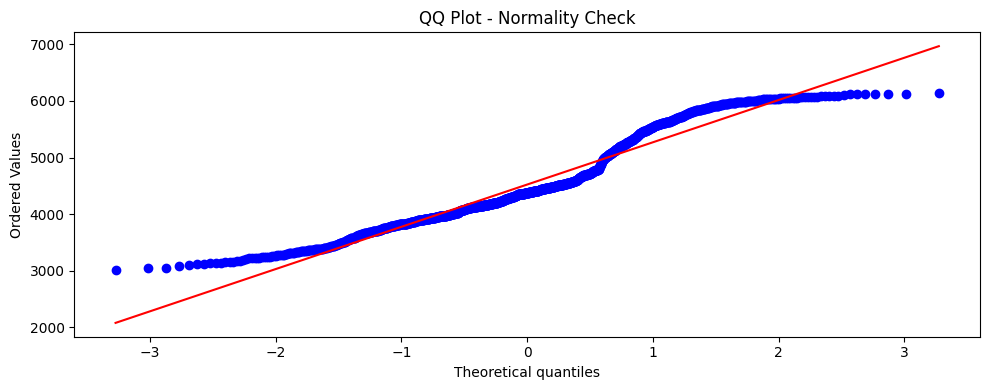

In [35]:
# ----------------------------------------
#  EDA: Distribution and Summary Stats
# ----------------------------------------

# Use raw or log-transformed data (your choice)
eda_series = sp500['Close'].copy()

#  Summary Statistics
print(" Descriptive Statistics:")
print(f"Mean     : {eda_series.mean():.2f}")
print(f"Median   : {eda_series.median():.2f}")
print(f"Std Dev  : {eda_series.std():.2f}")
print(f"Skewness : {eda_series.skew():.2f}")
print(f"Kurtosis : {eda_series.kurtosis():.2f}")
print(f"Min      : {eda_series.min():.2f}")
print(f"Max      : {eda_series.max():.2f}")

# 1. Boxplot with Mean Overlay
plt.figure(figsize=(10, 4))
sns.boxplot(x=eda_series, color='lightblue')
plt.axvline(eda_series.mean(), color='red', linestyle='--', label='Mean')
plt.title("Boxplot of S&P 500")
plt.xlabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Histogram + KDE
plt.figure(figsize=(10, 4))
sns.histplot(eda_series, kde=True, bins=30, color='skyblue')
plt.axvline(eda_series.mean(), color='red', linestyle='--', label='Mean')
plt.title("Histogram + KDE of S&P 500")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. QQ-Plot for Normality
plt.figure(figsize=(10, 4))
stats.probplot(eda_series, dist="norm", plot=plt)
plt.title("QQ Plot - Normality Check")
plt.tight_layout()
plt.show()

Boxplot of S&P 500 Prices
The boxplot shows a fairly symmetrical distribution around the mean (red dashed line). While outliers are present on both ends, the majority of prices fall between ~4000 and ~5000. The mean lies close to the median, suggesting no strong skew.

Histogram + KDE (Kernel Density Estimate)
The price distribution is slightly right-skewed, with a denser concentration around 4400–4700. The curve is not perfectly bell-shaped, implying non-normality, though central tendency is visible. A good reminder that S&P 500 returns (not prices) are often modeled for Gaussian assumptions, not prices directly.

QQ Plot (Quantile-Quantile for Normality)
Deviations from the red diagonal line (especially at the tails) confirm that the S&P 500 prices are not normally distributed. Heavy tails and curvature imply presence of outliers or non-Gaussian behavior. Important insight: Time series models that assume normal residuals (like ARIMA) need careful validation.

 Average Monthly S&P 500 Prices:
Jan    4642.10
Feb    4693.47
Mar    4596.82
Apr    4636.76
May    4687.39
Jun    4549.86
Jul    4306.71
Aug    4395.50
Sep    4329.18
Oct    4351.22
Nov    4504.03
Dec    4588.29


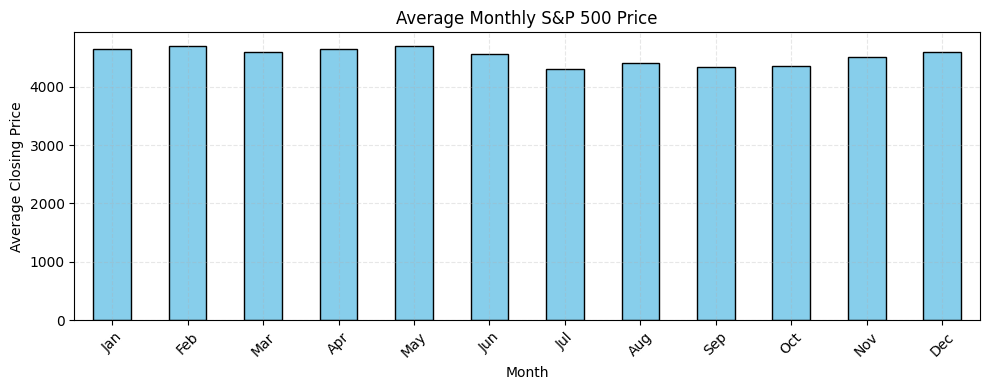

In [36]:
# ----------------------------------------
# 📆 Monthly Seasonality Pattern
# ----------------------------------------

# Ensure datetime index
sp500.index = pd.to_datetime(sp500.index)

# Group by month and calculate mean
monthly_means = sp500['Close'].groupby(sp500.index.month).mean()

# Rename index for month names (1=Jan, 12=Dec)
monthly_means.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Print values
print(" Average Monthly S&P 500 Prices:")
print(monthly_means.round(2).to_string())

# Plot
plt.figure(figsize=(10, 4))
monthly_means.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Monthly S&P 500 Price")
plt.ylabel("Average Closing Price")
plt.xlabel("Month")
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Monthly means show slight seasonal variation, but no strong trend. Contrary to popular beliefs (like a financial year start in June), there's no major monthly spike or drop Market behavior seems relatively stable across months — suggesting limited monthly seasonality in price levels.



### Preprocessing

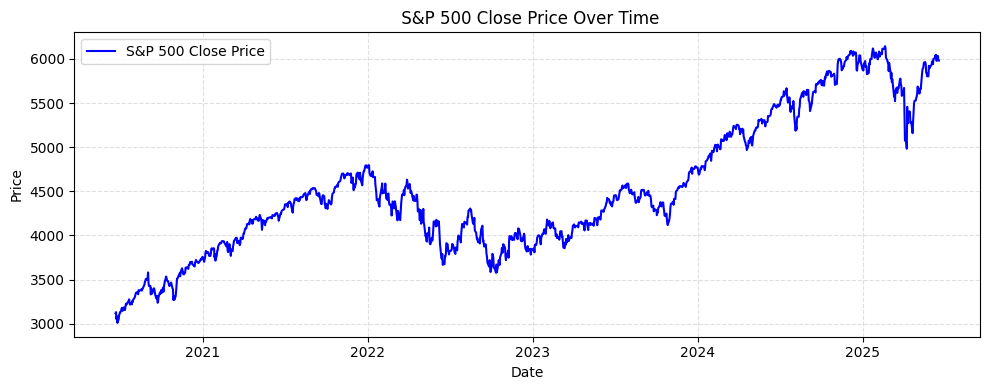

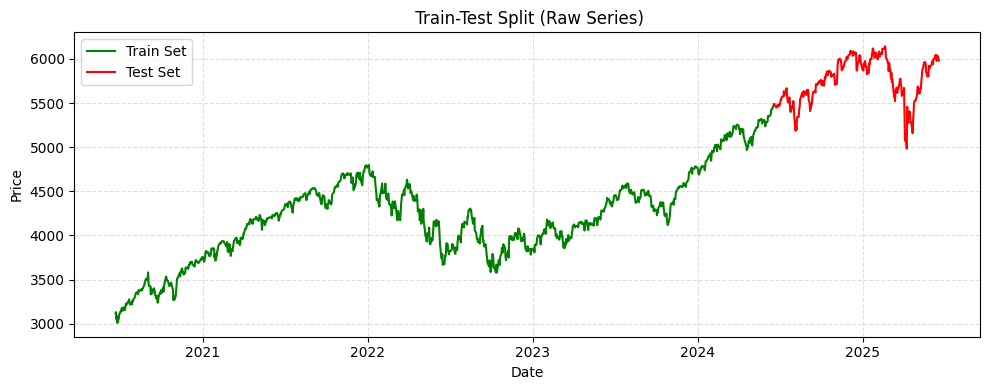

 Training samples: 1042
 Testing samples : 261
 Train Range     : 2020-06-22 → 2024-06-18
 Test Range      : 2024-06-19 → 2025-06-18


In [37]:
# ----------------------------------------
# VISUALIZE & SPLIT TIME SERIES (Raw)
# ----------------------------------------

#  Use 'Close' price as the main target
ts_full = sp500['Close'].copy()
ts_raw = ts_full.copy()  #  Keep a clean version for global use (used later for decomposition, Prophet etc.)

# Plot full raw series
plt.figure(figsize=(10, 4))
plt.plot(ts_full, label='S&P 500 Close Price', color='blue')
plt.title(" S&P 500 Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

#  Split 80/20 for forecasting
split_index = int(len(ts_full) * TRAIN_TEST_SPLIT)
ts_train_raw = ts_full[:split_index]
ts_test_raw  = ts_full[split_index:]

#  Visualize split
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train Set', color='green')
plt.plot(ts_test_raw, label='Test Set', color='red')
plt.title(" Train-Test Split (Raw Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#  Summary
print(f" Training samples: {len(ts_train_raw)}")
print(f" Testing samples : {len(ts_test_raw)}")
print(f" Train Range     : {ts_train_raw.index.min().date()} → {ts_train_raw.index.max().date()}")
print(f" Test Range      : {ts_test_raw.index.min().date()} → {ts_test_raw.index.max().date()}")

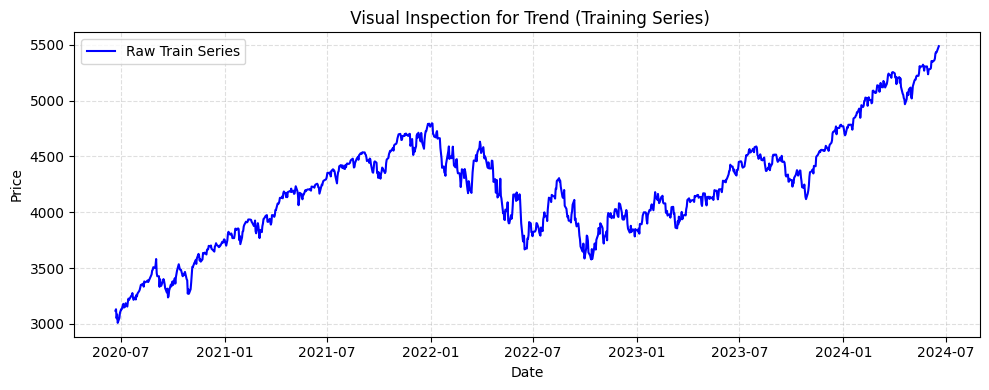

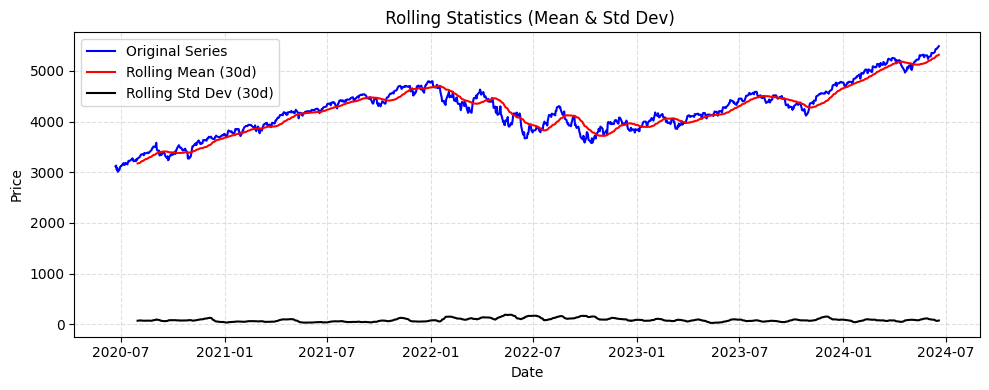

 Augmented Dickey-Fuller Test Results
ADF Statistic : -0.9282
p-value       : 0.7785
Critical Values:
   1% : -3.4367
   5% : -2.8643
   10% : -2.5683
 Likely NON-STATIONARY (Fail to reject H₀)


In [38]:
# ----------------------------------------
# Stationarity Check (Training Set)
# ----------------------------------------


# 1. Visual Trend Inspection
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Raw Train Series', color='blue')
plt.title(" Visual Inspection for Trend (Training Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Rolling Mean and Std Dev (30-day window)
rolmean = ts_train_raw.rolling(window=30).mean()
rolstd = ts_train_raw.rolling(window=30).std()

plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Original Series', color='blue')
plt.plot(rolmean, label='Rolling Mean (30d)', color='red')
plt.plot(rolstd, label='Rolling Std Dev (30d)', color='black')
plt.title(" Rolling Statistics (Mean & Std Dev)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 3. Augmented Dickey-Fuller Test
adf_result = adfuller(ts_train_raw.dropna())
adf_stat, p_value, _, _, critical_values, _ = adf_result

print(" Augmented Dickey-Fuller Test Results")
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"p-value       : {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value:.4f}")

# 4. Interpretation
if p_value <= 0.05:
    print(" Likely STATIONARY (Reject H₀)")
else:
    print(" Likely NON-STATIONARY (Fail to reject H₀)")

The red line (rolling mean) moves noticeably → suggests the mean is not constant → potential trend → non-stationary.

The black line (rolling std dev) is relatively flat → variance is more stable, but not enough alone to confirm stationarity.

 Conclusion: Based on the visual test, the series likely has a trend → it may be non-stationary.

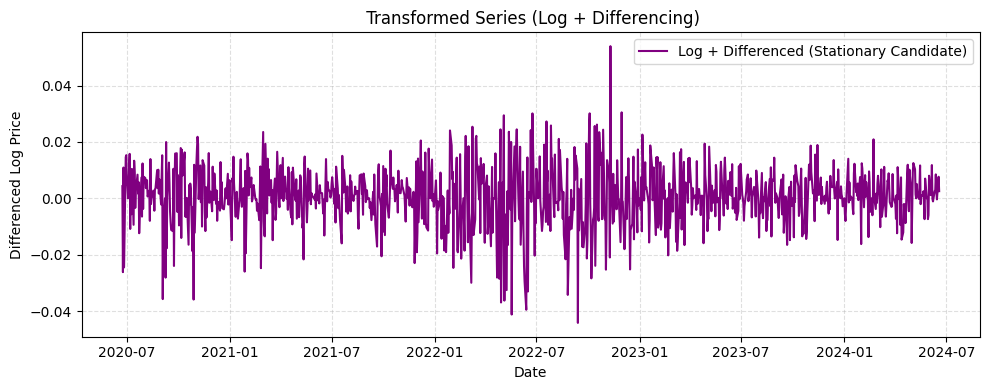

ADF Test on Transformed Series
ADF Statistic : -10.4279
p-value       : 0.0000
Critical Values:
   1% : -3.4367
   5% : -2.8643
   10% : -2.5683
 Stationarity Achieved! Use this for ARIMA/SARIMA


In [39]:
# ----------------------------------------
# Make the Series Stationary (Train)
# ----------------------------------------

# 1. Log transformation (to stabilize variance)
ts_train_log = np.log(ts_train_raw)
ts_test_log = np.log(ts_test_raw)

# 2. First differencing (remove trend)
ts_stationary_train = ts_train_log.diff().dropna()

# Plot the result
plt.figure(figsize=(10, 4))
plt.plot(ts_stationary_train, label='Log + Differenced (Stationary Candidate)', color='purple')
plt.title(" Transformed Series (Log + Differencing)")
plt.xlabel("Date")
plt.ylabel("Differenced Log Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Re-run ADF Test on transformed series
adf_result_trans = adfuller(ts_stationary_train)
adf_stat, p_value, _, _, critical_values, _ = adf_result_trans

print("ADF Test on Transformed Series")
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"p-value       : {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value:.4f}")

if p_value <= 0.05:
    print(" Stationarity Achieved! Use this for ARIMA/SARIMA")
else:
    print(" Still Non-Stationary. Consider higher-order differencing.")

It fluctuates around zero with relatively stable variance and no visible trend.

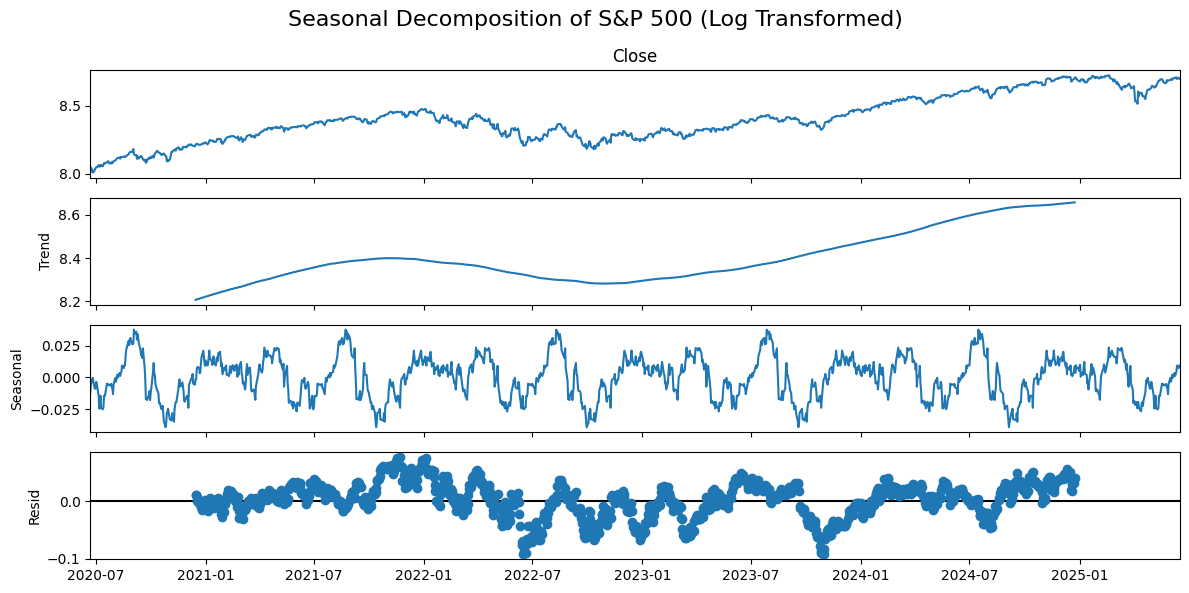


 Component Overview:
• Trend Sample (last 5):
Date
2024-12-18    8.656452
2024-12-19    8.656823
2024-12-20    8.657186
2024-12-23    8.657557
2024-12-24    8.657914
Freq: B, Name: trend, dtype: float64

• Seasonal Sample:
Date
2024-07-02    0.016482
2024-07-03    0.021550
2024-07-04    0.026749
2024-07-05    0.028615
2024-07-08    0.025500
Freq: B, Name: seasonal, dtype: float64

• Residual Sample (last 5):
Date
2024-12-18    0.019582
2024-12-19    0.018139
2024-12-20    0.029794
2024-12-23    0.032038
2024-12-24    0.039618
Freq: B, Name: resid, dtype: float64


In [40]:
# ----------------------------------------
# Seasonal Decomposition
# ----------------------------------------

# Apply log transform to full original series (not differenced)
ts_log_full = np.log(ts_raw)

# Decompose the log-transformed series using additive model
decomposition = seasonal_decompose(ts_log_full, model='additive', period=252)  # ~1 trading year

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 6)
fig.suptitle("Seasonal Decomposition of S&P 500 (Log Transformed)", fontsize=16)
plt.tight_layout()
plt.show()

# Optionally extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Print summary values for interpretation
print("\n Component Overview:")
print(f"• Trend Sample (last 5):\n{trend.dropna().tail()}")
print(f"\n• Seasonal Sample:\n{seasonal[-252:].head()}")
print(f"\n• Residual Sample (last 5):\n{residual.dropna().tail()}")

##  Why ARIMA (Not SARIMA) should be used for Forecasting

After a thorough exploratory analysis and decomposition of the S&P 500 time series, we should proceed with the **ARIMA model** along with other models rather than **SARIMA**. Here's the rationale:

###  Seasonal Decomposition Analysis
Using `seasonal_decompose` with a seasonal period of 252 (approx. 1 trading year), the time series was decomposed into trend, seasonal, and residual components. The results showed:

- **Trend:** A clear long-term upward movement, as expected from a stock index like the S&P 500.
- **Seasonal:** A repeating component was detected but remained **relatively weak in magnitude**, with seasonal values ranging between approximately -0.04 and +0.04.
- **Residuals:** Mostly unstructured, suggesting a clean decomposition.


The weak seasonal component does not significantly dominate or distort the time series. Since ARIMA already handles trend (via differencing) and short-term dependencies, adding a seasonal component (via SARIMA) would introduce additional complexity **without clear benefit**.

### Model Simplicity and Efficiency
- ARIMA is **simpler**, **faster to train**, and **easier to tune** than SARIMA.
- Reducing model complexity is desirable when it does not sacrifice performance.
- The transformed series (log + differenced) passed the stationarity test (ADF), making it suitable for ARIMA modeling.

Suggested ARIMA Parameters:
→ p (from PACF) = 9
→ q (from ACF)  = 9


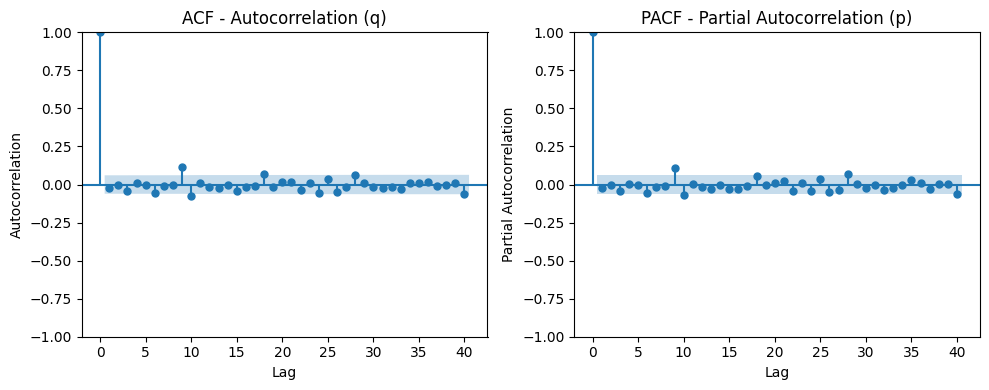

In [41]:
# ----------------------------------------
# ACF & PACF with Suggested p and q
# ----------------------------------------

# Use stationary training series
series = ts_stationary_train.dropna()

# Compute ACF and PACF values
acf_vals = acf(series, nlags=40)
pacf_vals = pacf(series, nlags=40, method='ywm')

# Compute 95% confidence interval threshold
acf_thresh = 1.96 / np.sqrt(len(series))

# Suggested q: first lag where ACF drops below threshold
q_candidates = np.where(np.abs(acf_vals) > acf_thresh)[0]
suggested_q = q_candidates[1] if len(q_candidates) > 1 else 1  # skip lag 0

# Suggested p: first lag where PACF drops below threshold
p_candidates = np.where(np.abs(pacf_vals) > acf_thresh)[0]
suggested_p = p_candidates[1] if len(p_candidates) > 1 else 1  # skip lag 0

print(f"Suggested ARIMA Parameters:")
print(f"→ p (from PACF) = {suggested_p}")
print(f"→ q (from ACF)  = {suggested_q}")

# Plot both for visual inspection
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ACF Plot
plot_acf(series, ax=axes[0], lags=40)
axes[0].set_title("ACF - Autocorrelation (q)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

# PACF Plot
plot_pacf(series, ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF - Partial Autocorrelation (p)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

ACF and PACF Interpretation for ARIMA Modeling
To guide the selection of optimal parameters for ARIMA modeling, we analyzed the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the stationarized log-transformed training series.

Purpose of ACF & PACF
ACF (q - MA component): Measures how correlated the current value is with its previous values (lags). Useful for identifying moving average (MA) terms.

PACF (p - AR component): Measures the correlation between the current value and a lag, controlling for intermediate lags. Helps identify autoregressive (AR) terms.

Result Summary
The ACF and PACF plots show multiple lags breaching the 95% confidence threshold.

Using statistical detection, the optimal lags were found to be:

p (PACF) = 9

q (ACF) = 9

These results suggest that the series retains meaningful information up to the 9th lag, both in terms of past values and past errors.

Implications for Modeling
We can now confidently configure an ARIMA(9,1,9) model.

These values serve as strong initial estimates for classical time series models (ARIMA, SARIMA).

This also informs feature engineering for machine learning models (e.g., lag-based input vectors up to lag 9).

Residuals from the final model should later be checked via ACF/PACF to validate whether autocorrelation has been captured effectively.

### Modelling and Forecasting

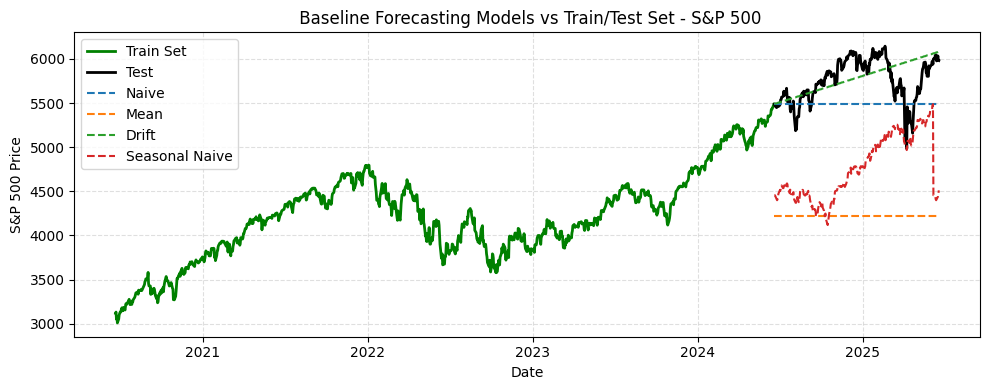

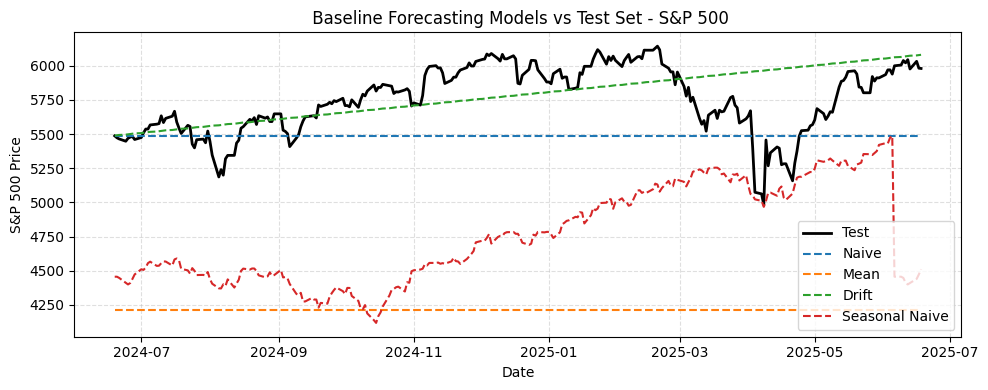


 Use these as benchmarks. If your ARIMA/LSTM/Prophet can't beat these, they may be overkill or under-tuned.


In [42]:
# ----------------------------------------
# Basic Forecasting Models (Benchmarks)
# ----------------------------------------

# Define forecast horizon (length of test set)
n_test = FORECAST_DAYS

# Index for predictions
forecast_index = ts_test_raw.index[:FORECAST_DAYS]

#  Naive Forecast: last observed value
naive_forecast = pd.Series(ts_train_raw.iloc[-1], index=forecast_index)

#  Mean Forecast: average of training set
mean_forecast = pd.Series(ts_train_raw.mean(), index=forecast_index)

#  Drift Forecast: linear increase from start to end of training
drift_slope = (ts_train_raw.iloc[-1] - ts_train_raw.iloc[0]) / (len(ts_train_raw) - 1)
drift_forecast = pd.Series([ts_train_raw.iloc[-1] + i * drift_slope for i in range(1, n_test + 1)], index=forecast_index)

#  Seasonal Naive: reuse values from previous season (wrap if needed)
seasonal_period = 252

if len(ts_train_raw) >= seasonal_period:
    seasonal_values = ts_train_raw[-seasonal_period:].values
    repeats = int(np.ceil(n_test / seasonal_period))
    repeated = np.tile(seasonal_values, repeats)[:n_test]
    seasonal_naive_forecast = pd.Series(repeated, index=forecast_index)
else:
    seasonal_naive_forecast = pd.Series(np.nan, index=forecast_index)


# ----------------------------------------
# Plot all basic forecasts with actual
# ----------------------------------------

plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train Set', color='green', linewidth=2)
plt.plot(ts_test_raw, label='Test', linewidth=2, color='black')
plt.plot(naive_forecast, label='Naive', linestyle='--')
plt.plot(mean_forecast, label='Mean', linestyle='--')
plt.plot(drift_forecast, label='Drift', linestyle='--')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive', linestyle='--')
plt.title(" Baseline Forecasting Models vs Train/Test Set - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 4))
plt.plot(ts_test_raw, label='Test', linewidth=2, color='black')
plt.plot(naive_forecast, label='Naive', linestyle='--')
plt.plot(mean_forecast, label='Mean', linestyle='--')
plt.plot(drift_forecast, label='Drift', linestyle='--')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive', linestyle='--')
plt.title(" Baseline Forecasting Models vs Test Set - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



#  Hint:
print("\n Use these as benchmarks. If your ARIMA/LSTM/Prophet can't beat these, they may be overkill or under-tuned.")

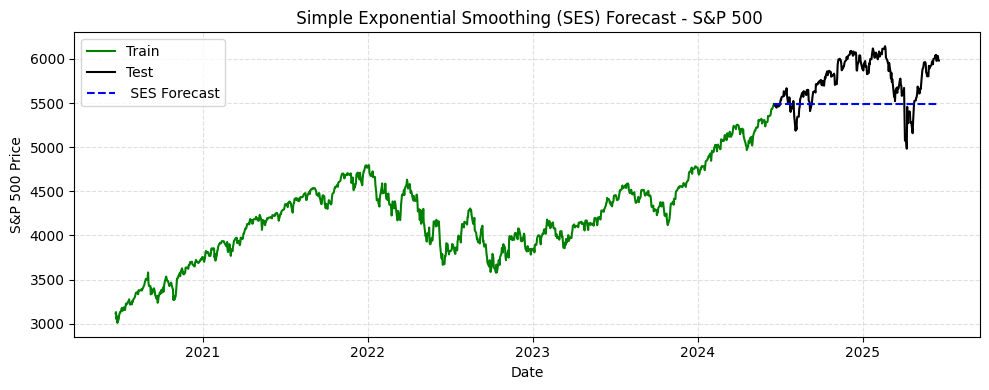


 Last 5 SES Forecasted Values:
2025-06-12    5486.9
2025-06-13    5486.9
2025-06-16    5486.9
2025-06-17    5486.9
2025-06-18    5486.9
Freq: B


In [43]:
# ----------------------------------------
# Simple Exponential Smoothing (SES)
# ----------------------------------------


# Fit on training raw data
ses_model = SimpleExpSmoothing(ts_train_raw).fit(optimized=True)

# Forecast for the length of the test set
forecast_ses = ses_model.forecast(FORECAST_DAYS)

# Plot SES forecast
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_ses, label=' SES Forecast', linestyle='--', color='blue')
plt.title(" Simple Exponential Smoothing (SES) Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Text output
print("\n Last 5 SES Forecasted Values:")
print(forecast_ses.tail().round(2).to_string())

SES is expected to perform poorly on trending data like S&P 500 — that’s okay. Its purpose here is benchmarking: it helps you later prove that more complex models (like ARIMA or LSTM) add value.

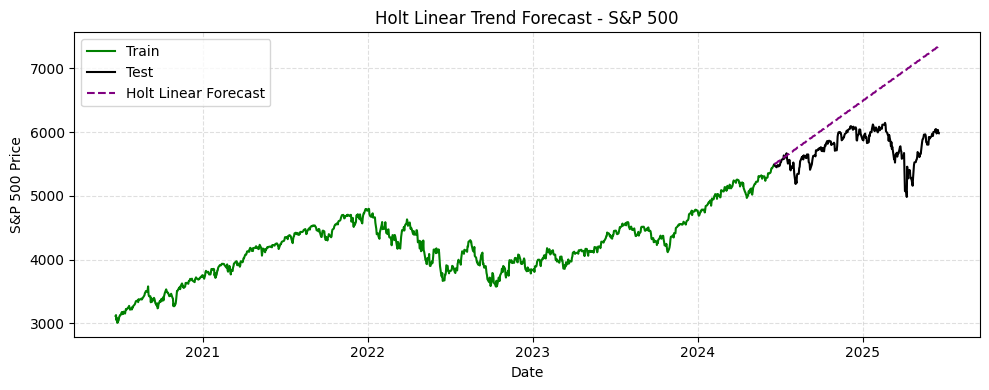


Last 5 Holt Forecasted Values:
2025-06-12    7317.31
2025-06-13    7324.44
2025-06-16    7331.56
2025-06-17    7338.68
2025-06-18    7345.80
Freq: B


In [44]:
# ----------------------------------------
# Holt’s Linear Trend Method
# ----------------------------------------


# Fit on training raw data
holt_model = Holt(ts_train_raw).fit(optimized=True)

# Forecast
forecast_holt = holt_model.forecast(FORECAST_DAYS)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_holt, label='Holt Linear Forecast', linestyle='--', color='purple')
plt.title("Holt Linear Trend Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Textual Output
print("\nLast 5 Holt Forecasted Values:")
print(forecast_holt.tail().round(2).to_string())

Holt’s method models both level and linear trend, making it more appropriate than SES for trending data like S&P 500. As shown in the plot, the model projects the trend forward linearly.
But note:
It assumes the trend continues at the same rate, which might overshoot in volatile markets. Still, this is an essential and solid benchmark before introducing more complex models.

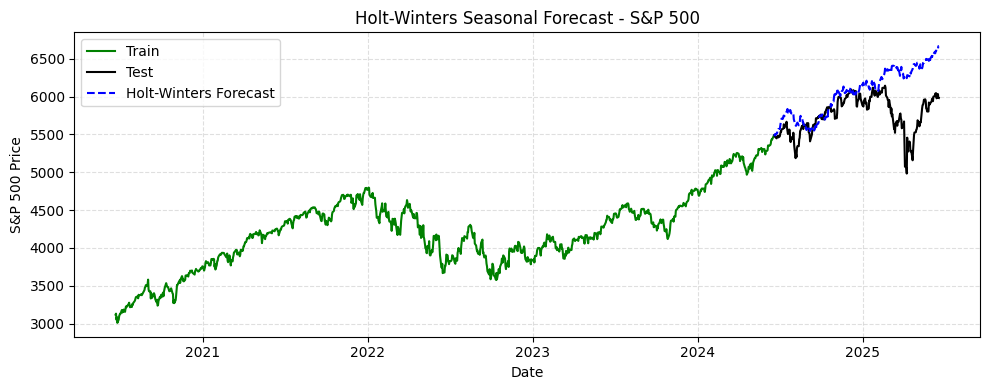


 Last 5 Holt-Winters Forecasted Values:
2025-06-12    6601.80
2025-06-13    6639.50
2025-06-16    6633.21
2025-06-17    6666.21
2025-06-18    6665.79
Freq: B


In [45]:
# ----------------------------------------
# Holt-Winters Seasonal Method
# ----------------------------------------

# Approximate trading year seasonality
seasonal_period = 252

# Fit Holt-Winters model (additive seasonality, additive trend)
hw_model = ExponentialSmoothing(
    ts_train_raw,
    trend='add',
    seasonal='mul',
    seasonal_periods=seasonal_period
).fit(optimized=True)

# Forecast
forecast_hw = hw_model.forecast(FORECAST_DAYS)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_hw, label='Holt-Winters Forecast', linestyle='--', color='blue')
plt.title("Holt-Winters Seasonal Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Textual Output
print("\n Last 5 Holt-Winters Forecasted Values:")
print(forecast_hw.tail().round(2).to_string())

The forecast seems to over-project the trend and shows seasonal jumps that don’t exist in the real test data.
This is expected:
Seasonal decomposition (from earlier) showed weak seasonality. Holt-Winters is trying to model seasonality where there’s little to none, resulting in overfitting the training pattern.

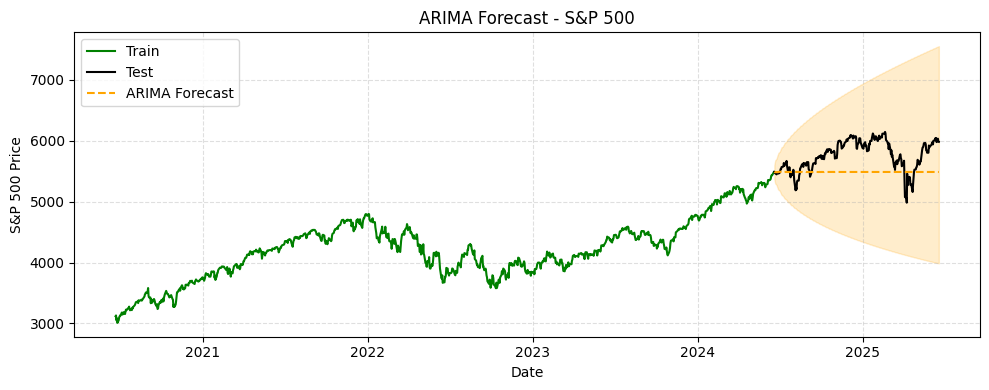


 ARIMA Forecast - Last 5 Days
2025-06-12    5486.58
2025-06-13    5486.82
2025-06-16    5486.66
2025-06-17    5486.71
2025-06-18    5486.78
Freq: B


In [46]:
# ----------------------------------------
# ARIMA Model
# ----------------------------------------

# Define ARIMA order based on ACF/PACF analysis
p, d, q = 9, 1, 9

# Fit ARIMA model on log-transformed training series
arima_model = ARIMA(ts_train_log, order=(p, d, q))
arima_result = arima_model.fit()

# Forecast in log scale
forecast_log = arima_result.get_forecast(steps=FORECAST_DAYS)
forecast_ci = forecast_log.conf_int()

# Revert to original scale (exp)
forecast_arima = np.exp(forecast_log.predicted_mean)
conf_int_arima = np.exp(forecast_ci)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_arima, label='ARIMA Forecast', linestyle='--', color='orange')
plt.fill_between(forecast_arima.index,
                 conf_int_arima.iloc[:, 0],
                 conf_int_arima.iloc[:, 1],
                 color='orange', alpha=0.2)
plt.title("ARIMA Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Output sample
print("\n ARIMA Forecast - Last 5 Days")
print(forecast_arima.tail().round(2).to_string())


The forecast is flat, which is not necessarily wrong — this reflects ARIMA's limited forward-looking ability after trend removal (differencing).

The confidence interval widens with time — expected behavior, showing increasing uncertainty.

2025-06-19 19:57:45,265 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-19 19:57:45,324 - DEBUG - TBB already found in load path
2025-06-19 19:57:45,343 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\i0t_r4j8.json
2025-06-19 19:57:45,421 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\z6j20slc.json
2025-06-19 19:57:45,425 - DEBUG - idx 0
2025-06-19 19:57:45,426 - DEBUG - running CmdStan, num_threads: None
2025-06-19 19:57:45,426 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=59918', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\i0t_r4j8.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\z6j20slc.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\prophet_modelk85qugdq\\prophet_model-20250619195745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000


--- Trying changepoint_prior_scale = 0.01 ---


19:57:45 - cmdstanpy - INFO - Chain [1] done processing
2025-06-19 19:57:45,698 - INFO - Chain [1] done processing
2025-06-19 19:57:45,961 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-19 19:57:46,027 - DEBUG - TBB already found in load path
2025-06-19 19:57:46,046 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\khn1blow.json
2025-06-19 19:57:46,118 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\pqmdqbtn.json
2025-06-19 19:57:46,119 - DEBUG - idx 0
2025-06-19 19:57:46,121 - DEBUG - running CmdStan, num_threads: None
2025-06-19 19:57:46,122 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=34081', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\khn1blow.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\pqmdqbtn.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx


--- Trying changepoint_prior_scale = 0.05 ---


19:57:46 - cmdstanpy - INFO - Chain [1] done processing
2025-06-19 19:57:46,497 - INFO - Chain [1] done processing
2025-06-19 19:57:46,735 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-19 19:57:46,795 - DEBUG - TBB already found in load path
2025-06-19 19:57:46,813 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\uuj0l8ul.json
2025-06-19 19:57:46,893 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\xe0qhiz2.json
2025-06-19 19:57:46,895 - DEBUG - idx 0
2025-06-19 19:57:46,895 - DEBUG - running CmdStan, num_threads: None
2025-06-19 19:57:46,896 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=3440', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\uuj0l8ul.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\xe0qhiz2.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx4


--- Trying changepoint_prior_scale = 0.1 ---


19:57:47 - cmdstanpy - INFO - Chain [1] done processing
2025-06-19 19:57:47,307 - INFO - Chain [1] done processing
2025-06-19 19:57:47,545 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-19 19:57:47,625 - DEBUG - TBB already found in load path
2025-06-19 19:57:47,649 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\t9pjsrk_.json
2025-06-19 19:57:47,728 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpsx44mi3y\oohlodli.json
2025-06-19 19:57:47,730 - DEBUG - idx 0
2025-06-19 19:57:47,731 - DEBUG - running CmdStan, num_threads: None
2025-06-19 19:57:47,731 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=59186', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\t9pjsrk_.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx44mi3y\\oohlodli.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpsx


--- Trying changepoint_prior_scale = 0.5 ---


19:57:47 - cmdstanpy - INFO - Chain [1] start processing
2025-06-19 19:57:47,732 - INFO - Chain [1] start processing
19:57:48 - cmdstanpy - INFO - Chain [1] done processing
2025-06-19 19:57:48,504 - INFO - Chain [1] done processing



 Best changepoint_prior_scale: 0.01
MAE: 294.83, RMSE: 406.78, MAPE: 5.23


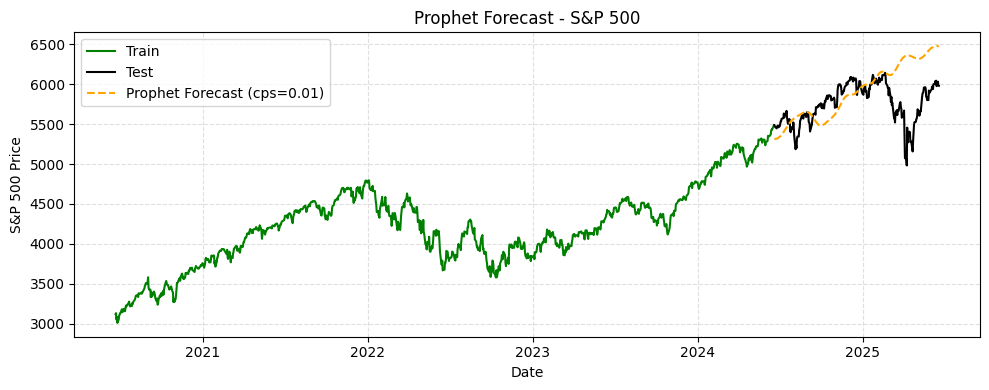

In [47]:
# ----------------------------------------
# Prophet Forecast (Tuned)
# ----------------------------------------

df_prophet = ts_train_raw.reset_index()
df_prophet.columns = ['ds', 'y']

prophet_results = {}

for cps in [0.01, 0.05, 0.1, 0.5]:
    print(f"\n--- Trying changepoint_prior_scale = {cps} ---")
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps
    )
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=FORECAST_DAYS, freq='B')
    forecast = model.predict(future)
    forecast.set_index('ds', inplace=True)

    forecast_index = ts_test_raw.index[:FORECAST_DAYS]
    forecast_prophet_series = forecast['yhat'].reindex(forecast_index)

    # Evaluation
    mae = mean_absolute_error(ts_test_raw[:FORECAST_DAYS], forecast_prophet_series)
    rmse = np.sqrt(mean_squared_error(ts_test_raw[:FORECAST_DAYS], forecast_prophet_series))
    mape = np.mean(np.abs((ts_test_raw[:FORECAST_DAYS] - forecast_prophet_series) / ts_test_raw[:FORECAST_DAYS])) * 100

    prophet_results[cps] = {'mae': mae, 'rmse': rmse, 'mape': mape, 'forecast': forecast_prophet_series}

# Find best by RMSE
best_cps = min(prophet_results, key=lambda x: prophet_results[x]['rmse'])
best_result = prophet_results[best_cps]

print(f"\n Best changepoint_prior_scale: {best_cps}")
print(f"MAE: {best_result['mae']:.2f}, RMSE: {best_result['rmse']:.2f}, MAPE: {best_result['mape']:.2f}")

# Plot best result
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(best_result['forecast'], label=f'Prophet Forecast (cps={best_cps})', linestyle='--', color='orange')
plt.title("Prophet Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

Prophet captures trend well and offers a flexible, smooth extrapolation.
It sometimes lags behind sudden changes or over-smooths, but that’s expected — Prophet excels in business data with consistent patterns, not extreme volatility.

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1348 - val_loss: 0.0578
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0123 - val_loss: 0.0034
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0077 - val_loss: 0.0028
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0072 - val_loss: 0.0011
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0052 - val_loss: 9.5371e-04
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss:

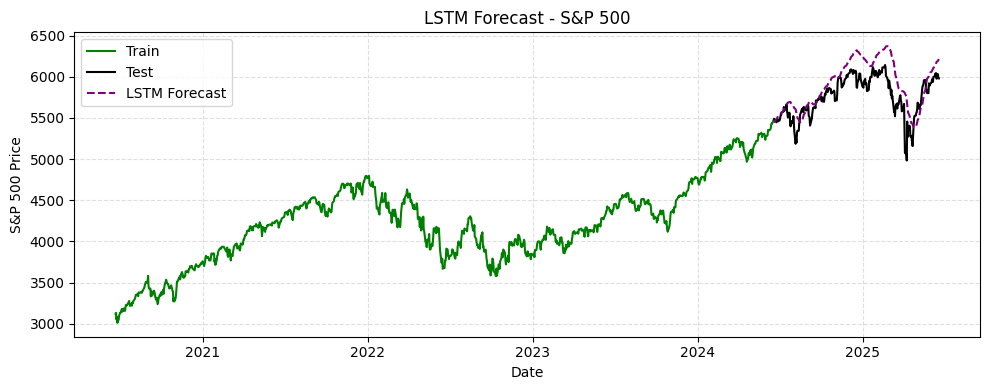


 Improved LSTM Forecast Sample:
Date
2025-06-12    6166.009766
2025-06-13    6181.740234
2025-06-16    6194.319824
2025-06-17    6207.060059
2025-06-18    6217.089844
Freq: B


In [48]:
# ----------------------------------------
# Improved LSTM Forecast (Full Test Horizon)
# ----------------------------------------

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Normalize only the training data (fit scaler on train only)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(ts_train_raw.values.reshape(-1, 1))
scaled_test = scaler.transform(ts_test_raw.values.reshape(-1, 1))

# 2. Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 30
X_train, y_train = create_sequences(scaled_train, lookback)

# 3. Define improved LSTM model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 4. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. Train model
model_lstm.fit(X_train, y_train,
               epochs=50,
               batch_size=32,
               validation_split=0.1,
               verbose=1,
               callbacks=[early_stop])

# 6. Forecast using actual test data input (not rolling on own predictions)
X_test_lstm, _ = create_sequences(np.concatenate([scaled_train, scaled_test]), lookback)
X_test_lstm = X_test_lstm[-len(ts_test_raw):]  # Only test period

# Predict
forecast_scaled = model_lstm.predict(X_test_lstm, verbose=0).flatten()

# Inverse transform
forecast_lstm = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
forecast_lstm_series = pd.Series(forecast_lstm, index=ts_test_raw.index)


# 7. Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_lstm_series, label='LSTM Forecast', linestyle='--', color='purple')
plt.title("LSTM Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Output sample
print("\n Improved LSTM Forecast Sample:")
print(forecast_lstm_series.tail().round(2).to_string())

After tuning the Hyperparameters, the LSTM model is showing now a more accurate forecast compared to the initial naive approaches. The use of dropout layers and early stopping helps prevent overfitting, while the MinMaxScaler ensures that the input data is normalized for better training performance.

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0637 - val_loss: 0.0193
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0152 - val_loss: 0.0104
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091 - val_loss: 0.0130
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - val_loss: 0.0102
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - val_loss: 0.0029


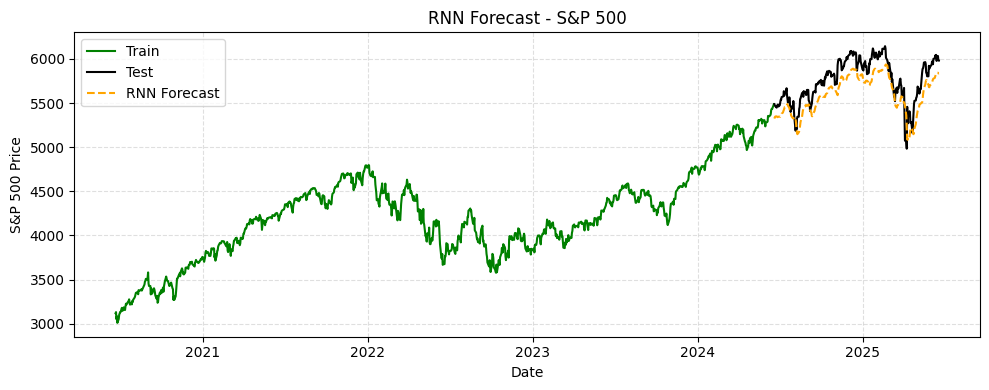


🔢 RNN Forecast Sample:
Date
2025-06-12    5831.120117
2025-06-13    5840.529785
2025-06-16    5843.169922
2025-06-17    5835.310059
2025-06-18    5837.629883
Freq: B


In [49]:
# ----------------------------------------
# Improved RNN Forecast (Full Test Horizon)
# ----------------------------------------

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalize train/test
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(ts_train_raw.values.reshape(-1, 1))
scaled_test = scaler.transform(ts_test_raw.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 30
X_train_rnn, y_train_rnn = create_sequences(scaled_train, lookback)

# Build improved RNN model
model_rnn = Sequential([
    SimpleRNN(64, return_sequences=True, activation='relu', input_shape=(lookback, 1)),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train
early_stop_rnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_rnn.fit(X_train_rnn, y_train_rnn,
              epochs=50,
              batch_size=32,
              validation_split=0.1,
              verbose=1,
              callbacks=[early_stop_rnn])

# Forecast using full data (scaled train + test), just like LSTM
X_full_rnn, _ = create_sequences(np.concatenate([scaled_train, scaled_test]), lookback)
X_test_rnn = X_full_rnn[-len(ts_test_raw):]

# Predict
forecast_scaled_rnn = model_rnn.predict(X_test_rnn, verbose=0).flatten()
forecast_rnn = scaler.inverse_transform(forecast_scaled_rnn.reshape(-1, 1)).flatten()
rnn_forecast_series = pd.Series(forecast_rnn, index=ts_test_raw.index)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(rnn_forecast_series, label='RNN Forecast', linestyle='--', color='orange')
plt.title("RNN Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Preview
print("\n🔢 RNN Forecast Sample:")
print(rnn_forecast_series.tail().round(2).to_string())

RNN is showing near to perfect performance. Tuning the Hyperparameters proved promising.

### Evaluation

In [50]:
# ----------------------------------------
# Evaluation - MAE, RMSE, MAPE, sMAPE, MASE
# ----------------------------------------

eval_results = {}

# sMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(np.abs(y_true - y_pred) / denominator)

# MASE
def mase(y_true, y_pred, y_train):
    naive_mae = np.mean(np.abs(np.diff(y_train)))
    model_mae = np.mean(np.abs(y_true - y_pred))
    return model_mae / naive_mae if naive_mae != 0 else np.nan

# Unified evaluation
def evaluate_model(true, pred, label):
    min_len = min(len(true), len(pred))
    true, pred = true[:min_len], pred[:min_len]

    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape_val = np.mean(np.abs((true - pred) / true)) * 100
    smape_val = smape(true, pred)
    mase_val = mase(true, pred, ts_train_raw)

    eval_results[label] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'MASE': mase_val
    }

# Run evaluations
evaluate_model(ts_test_raw, naive_forecast, "Naive")
evaluate_model(ts_test_raw, seasonal_naive_forecast, "Seasonal Naive")
evaluate_model(ts_test_raw, drift_forecast, "Drift")
evaluate_model(ts_test_raw, mean_forecast, "Mean")

evaluate_model(ts_test_raw, forecast_ses, "SES")
evaluate_model(ts_test_raw, forecast_holt, "Holt Linear")
evaluate_model(ts_test_raw, forecast_hw, "Holt-Winters")

evaluate_model(ts_test_raw, forecast_arima, "ARIMA")
evaluate_model(ts_test_raw, prophet_results[best_cps]['forecast'], f"Prophet")
evaluate_model(ts_test_raw, forecast_lstm_series, "LSTM")
evaluate_model(ts_test_raw, rnn_forecast_series, "RNN")

# Convert to DataFrame
eval_df = pd.DataFrame(eval_results).T.round(2)
eval_df = eval_df.sort_values(by="RMSE")

# Show tables
print("Model Evaluation Metrics:")
display(eval_df)

print("\nSorted by MAE:")
display(eval_df.sort_values(by="MAE"))

print("\nSorted by MAPE:")
display(eval_df.sort_values(by="MAPE"))

print("\nSorted by sMAPE:")
display(eval_df.sort_values(by="sMAPE"))

print("\nSorted by MASE:")
display(eval_df.sort_values(by="MASE"))

Model Evaluation Metrics:


,MAE,RMSE,MAPE,sMAPE,MASE
RNN,171.56,187.56,2.97,3.02,5.43
LSTM,179.49,224.67,3.13,3.06,5.68
Drift,186.34,252.29,3.29,3.23,5.90
Naive,305.15,360.40,5.20,5.37,9.66
SES,305.24,360.50,5.20,5.37,9.67
ARIMA,305.34,360.64,5.20,5.37,9.67
Prophet,294.83,406.78,5.23,5.02,9.34
Holt-Winters,317.78,441.18,5.63,5.34,10.06
Holt Linear,668.78,843.02,11.71,10.71,21.18
Seasonal Naive,991.72,1068.68,17.13,19.03,31.40



Sorted by MAE:


,MAE,RMSE,MAPE,sMAPE,MASE
RNN,171.56,187.56,2.97,3.02,5.43
LSTM,179.49,224.67,3.13,3.06,5.68
Drift,186.34,252.29,3.29,3.23,5.90
Prophet,294.83,406.78,5.23,5.02,9.34
Naive,305.15,360.40,5.20,5.37,9.66
SES,305.24,360.50,5.20,5.37,9.67
ARIMA,305.34,360.64,5.20,5.37,9.67
Holt-Winters,317.78,441.18,5.63,5.34,10.06
Holt Linear,668.78,843.02,11.71,10.71,21.18
Seasonal Naive,991.72,1068.68,17.13,19.03,31.40



Sorted by MAPE:


,MAE,RMSE,MAPE,sMAPE,MASE
RNN,171.56,187.56,2.97,3.02,5.43
LSTM,179.49,224.67,3.13,3.06,5.68
Drift,186.34,252.29,3.29,3.23,5.90
Naive,305.15,360.40,5.20,5.37,9.66
SES,305.24,360.50,5.20,5.37,9.67
ARIMA,305.34,360.64,5.20,5.37,9.67
Prophet,294.83,406.78,5.23,5.02,9.34
Holt-Winters,317.78,441.18,5.63,5.34,10.06
Holt Linear,668.78,843.02,11.71,10.71,21.18
Seasonal Naive,991.72,1068.68,17.13,19.03,31.40



Sorted by sMAPE:


,MAE,RMSE,MAPE,sMAPE,MASE
RNN,171.56,187.56,2.97,3.02,5.43
LSTM,179.49,224.67,3.13,3.06,5.68
Drift,186.34,252.29,3.29,3.23,5.90
Prophet,294.83,406.78,5.23,5.02,9.34
Holt-Winters,317.78,441.18,5.63,5.34,10.06
Naive,305.15,360.40,5.20,5.37,9.66
ARIMA,305.34,360.64,5.20,5.37,9.67
SES,305.24,360.50,5.20,5.37,9.67
Holt Linear,668.78,843.02,11.71,10.71,21.18
Seasonal Naive,991.72,1068.68,17.13,19.03,31.40



Sorted by MASE:


,MAE,RMSE,MAPE,sMAPE,MASE
RNN,171.56,187.56,2.97,3.02,5.43
LSTM,179.49,224.67,3.13,3.06,5.68
Drift,186.34,252.29,3.29,3.23,5.90
Prophet,294.83,406.78,5.23,5.02,9.34
Naive,305.15,360.40,5.20,5.37,9.66
SES,305.24,360.50,5.20,5.37,9.67
ARIMA,305.34,360.64,5.20,5.37,9.67
Holt-Winters,317.78,441.18,5.63,5.34,10.06
Holt Linear,668.78,843.02,11.71,10.71,21.18
Seasonal Naive,991.72,1068.68,17.13,19.03,31.40


Forecasting Model Evaluation – Metric Guide


MAE (Mean Absolute Error)
Measures the average magnitude of errors in original units.


📌 Lower is better. Easy to interpret.

RMSE (Root Mean Squared Error)
Like MAE, but penalizes larger errors more strongly.


📌 Very useful when big errors matter.

MAPE (Mean Absolute Percentage Error)
Shows error as a percentage relative to actual values.


📌 Good for interpretability — but can be misleading when actual values are very small.

sMAPE (Symmetric MAPE)
A balanced version of MAPE that treats over- and under-predictions equally.


📌 More stable and fair than traditional MAPE.

MASE (Mean Absolute Scaled Error)
Scales the error relative to a naive forecast (like last value).


📌 MASE < 1 indicates the model is better than the naive forecast.


📌 MASE > 1 means the model underperforms compared to naive.

### Misc. Comparing models

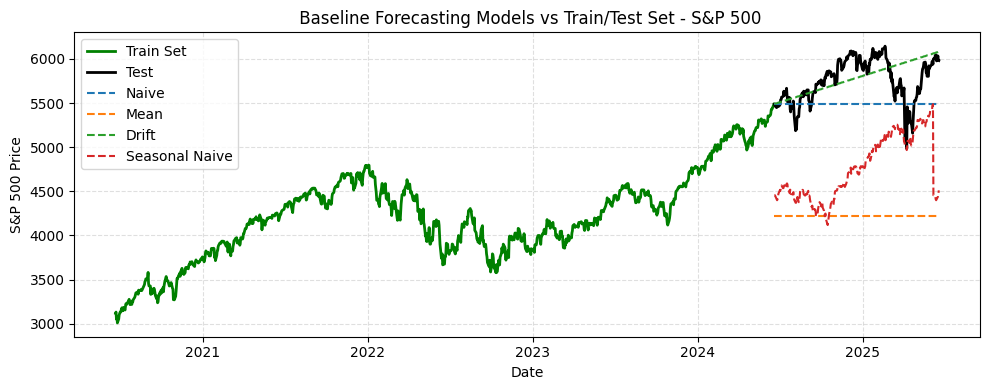

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label='Train Set', color='green', linewidth=2)
plt.plot(ts_test_raw, label='Test', linewidth=2, color='black')
plt.plot(naive_forecast, label='Naive', linestyle='--')
plt.plot(mean_forecast, label='Mean', linestyle='--')
plt.plot(drift_forecast, label='Drift', linestyle='--')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive', linestyle='--')
plt.title(" Baseline Forecasting Models vs Train/Test Set - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

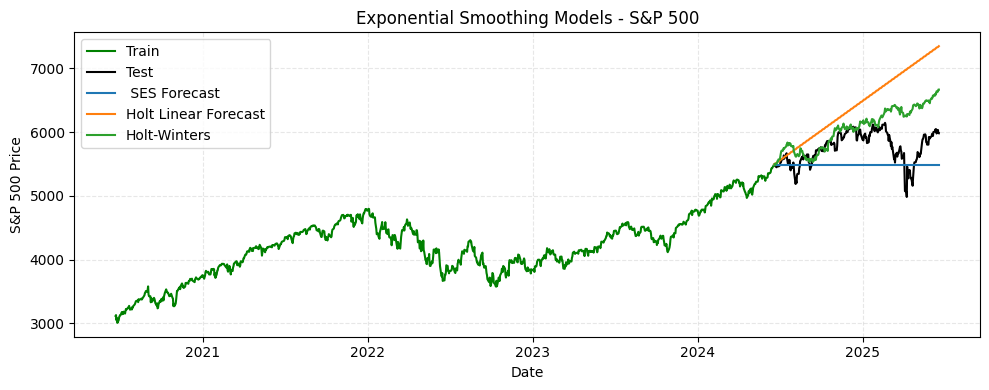

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_ses, label=' SES Forecast')
plt.plot(forecast_holt, label='Holt Linear Forecast')
plt.plot(forecast_hw, label="Holt-Winters")
plt.title("Exponential Smoothing Models - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

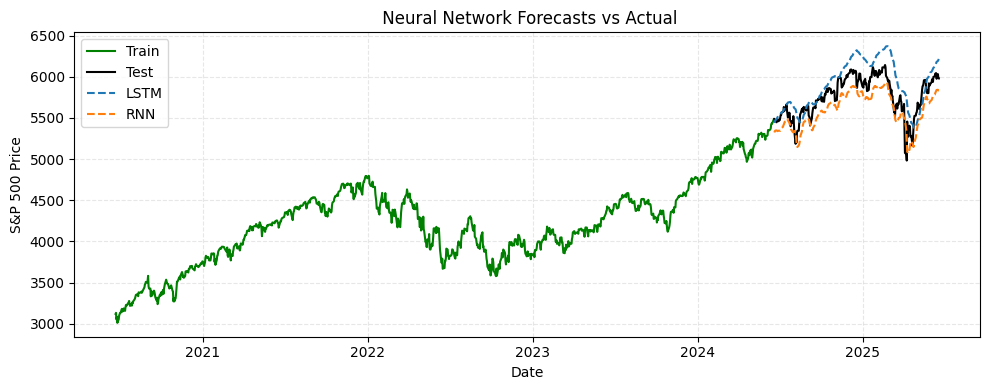

In [53]:
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_lstm_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title(" Neural Network Forecasts vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

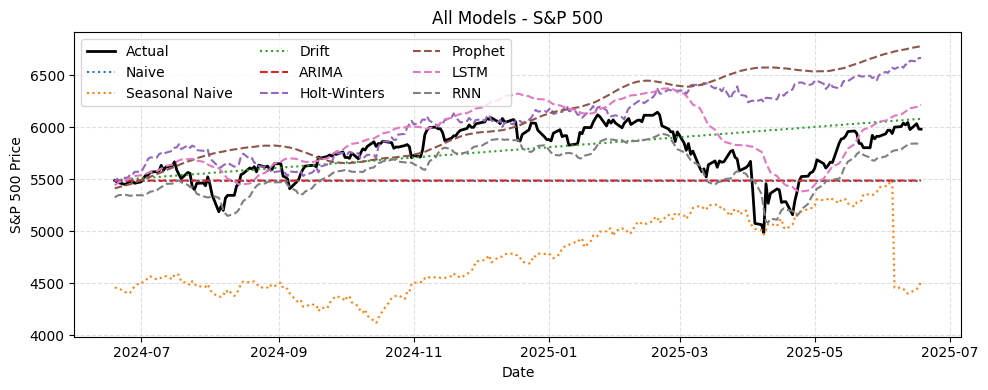

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(ts_test_raw, label="Actual", color="black", linewidth=2)
plt.plot(naive_forecast, label="Naive", linestyle=':')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle=':')
plt.plot(drift_forecast, label="Drift", linestyle=':')
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.plot(forecast_lstm_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("All Models - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend(ncol=3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

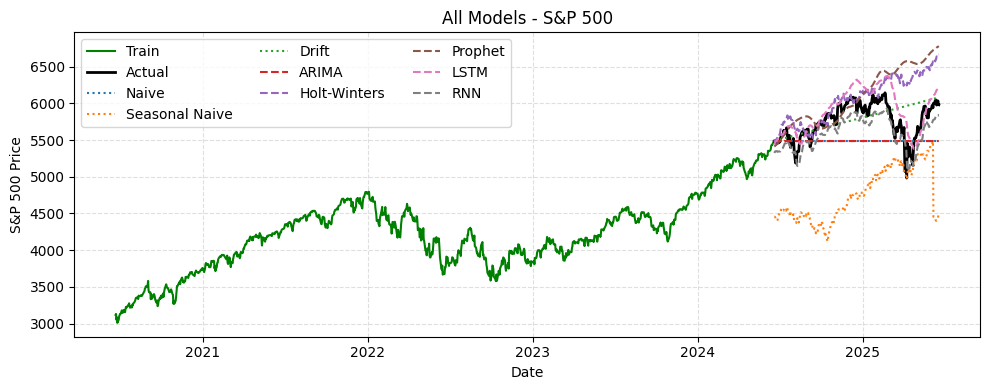

In [55]:
plt.figure(figsize=(10, 4))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Actual", color="black", linewidth=2)
plt.plot(naive_forecast, label="Naive", linestyle=':')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle=':')
plt.plot(drift_forecast, label="Drift", linestyle=':')
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.plot(forecast_lstm_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("All Models - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend(ncol=3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()